# 1. Data preprocessing

In [1]:
# %pip install matplotlib

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
import numpy as np
import pandas as pd
import re

In [3]:
# Read data
df1 = pd.read_json('domain1_train_data.json', lines=True)
df2 = pd.read_json('domain2_train_data.json', lines=True)

# Train dev split
df1_train, df1_dev = train_test_split(df1, stratify=df1['label'], random_state=42)
df2_train, df2_dev = train_test_split(df2, stratify=df2['label'], random_state=42)

# Join data in both domains for trating them jointly (Augmentation)
df_train = pd.concat([df1_train, df2_train]).reset_index(drop=True)
df_dev = pd.concat([df1_dev, df2_dev]).reset_index(drop=True)

# 3 DL Models (BiLSTM)

In [4]:
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)

In [5]:
# Weights function
def weights(df):
    w = list(len(df['label'])/df['label'].value_counts())
    sample_weights = [0] * df.shape[0]
    for idx, label in enumerate(df['label']):
        sample_weights[idx] = w[label]
    return sample_weights

# Prepare pytorch dataset
class Dataset(Dataset):
    def __init__(self, text, labels):
        self.text = text
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        text = torch.tensor(self.text[idx])
        label = torch.tensor(self.labels[idx])
        return text, label
    
# Define collate (pre_process) function
def collate_batch(batch):  
    texts, labels = zip(*batch)
    text_len = [len(txt) for txt in texts]
    text = nn.utils.rnn.pad_sequence(texts, batch_first=True).to(device)
    labels = torch.tensor(labels, dtype=torch.float32).to(device).reshape(-1,1)
    return text, labels, text_len

# Create datasets
train_DS = Dataset(df_train['text'], df_train['label'])
dev_DS = Dataset(df_dev['text'], df_dev['label'])

# Sample train data
sampler_tr = torch.utils.data.WeightedRandomSampler(weights(df_train), num_samples=len(train_DS), replacement=True)
sampler_ts = torch.utils.data.WeightedRandomSampler(weights(df_dev), num_samples=len(dev_DS), replacement=True)

# Create dataloaders
bs = 32
x_tr_dl = DataLoader(train_DS, batch_size=bs, collate_fn=collate_batch, sampler=sampler_tr)
x_dev_dl = DataLoader(dev_DS, batch_size=bs, collate_fn=collate_batch, sampler=sampler_ts)

In [6]:
# Bidirectional LSTM model
class BiLSTM(nn.Module):
    def __init__(self, 
                 vocab_size, 
                 embedding_dim, 
                 hidden_dim, 
                 output_dim, 
                 n_layers):
        super(BiLSTM, self).__init__()
        # Embeding Layer
        self.embedding = nn.Embedding(vocab_size, 
                                      embedding_dim, 
                                    #   padding_idx=0
                                      )
        # BiLSTM layer
        self.lstm = nn.LSTM(embedding_dim, 
                           hidden_dim, 
                           bidirectional=True, 
                           num_layers=n_layers, 
                           batch_first=True,
                           # ---------------------------------------------
                           dropout = 0.5
                           # ---------------------------------------------
                           )
        # Linear layer
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # x2: bidirectional

        # ---------------------------------------------
        # Dropout layer
        self.dropout = nn.Dropout(0.5)
        # ---------------------------------------------
    def forward(self, text, text_lengths):
        # Embeding 
        # ---------------------------------------------
        embedded = self.dropout(
            self.embedding(text)
        )
        # ---------------------------------------------
        # Batch packing
        packed_embedded = nn.utils.rnn.pack_padded_sequence(embedded,
                                                            text_lengths, 
                                                            batch_first=True, 
                                                            enforce_sorted=False)
        # BiLSTM pass
        output, (hidden, cell_state) = self.lstm(packed_embedded)
        # Concatenate hidden states in the BiLSTM
        # ---------------------------------------------
        hidden = self.dropout(
            torch.cat((hidden[-2, :, :], hidden[-1, :, :]), dim=1)
        )
        # ---------------------------------------------
        # Return the classifier's output
        return self.fc(hidden.squeeze(0))

In [7]:
# Instantiate the model
model = BiLSTM(vocab_size=90000, embedding_dim=128, hidden_dim=256, output_dim=1, n_layers=2).to(device)
print(model)

BiLSTM(
  (embedding): Embedding(90000, 128)
  (lstm): LSTM(128, 256, num_layers=2, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=512, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [8]:
# Loss fn
loss_fn = nn.BCEWithLogitsLoss()
# Optimizer
optimizer = torch.optim.Adam(model.parameters())

In [9]:
# Binary accuracy function
def binary_accuracy(predictions, y):
    rounded_preds = torch.round(torch.sigmoid(predictions)).squeeze()  # Ensure it's a 1D tensor
    correct = (rounded_preds == y).float()
    return correct.sum() / len(correct)

def compute_f1(predictions, labels):
    # Convert predictions to binary
    preds_binary = torch.round(torch.sigmoid(predictions))
    preds_binary = preds_binary.detach().cpu().numpy()
    labels = labels.detach().cpu().numpy()

    return f1_score(labels, preds_binary)

In [10]:
from tqdm import tqdm
from sklearn.metrics import f1_score
# Train
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    train_loss, total, acc, real, preds = 0, 0, 0, [], []
    for X, y, text_len in tqdm(dataloader):
        pred = model(X, text_len)               # Forward pass
        loss = loss_fn(pred, y)                 # Compute loss 
        loss.backward()                         # Backpropagation
        optimizer.step()                        # Update parameters
        optimizer.zero_grad()                   # Reset gradient
    
        # Metrics
        acc += torch.sum((pred>=0.5).float() == y)
        real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        preds.extend((pred>=0.5).int().detach().cpu().numpy().reshape(-1,1))
        train_loss += loss.item()
        total += len(y)
    # General metrics
    train_loss /= total
    return train_loss, acc/size, f1_score(real, preds)

In [11]:
# Test
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    model.eval()
    test_loss, total, acc, real, preds = 0, 0, 0, [], []
    with torch.no_grad():       # Specify no gradient
        for X, y, text_len in dataloader:
            pred = model(X, text_len)               # Forward pass   
            
            # Metrics
            acc += torch.sum((pred>=0.5).float() == y)
            real.extend((y>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            preds.extend((pred>=0.5).int().detach().cpu().numpy().reshape(-1,1))
            
            test_loss += loss_fn(pred, y).item()    # Compute loss  
            total += len(y)                         # Total observations

    # General metrics
    test_loss /= total
    return test_loss, acc/size, f1_score(real, preds)

In [12]:
from tqdm import tqdm, tqdm_notebook # show progress bar

# Epochs
epochs = 50
train_loss, valid_loss = [], []
print("Training BiLSTM network model!")
for t in range(epochs):
    tl, train_acc, f1_tr = train(x_tr_dl, model, loss_fn, optimizer)
    vl, valid_acc, f1_ts = test(x_dev_dl, model, loss_fn)
    # Losses to dict
    train_loss.append(tl)
    valid_loss.append(vl)

    # Print results
    tqdm.write(
        f'epoch #{t}\ttrain_acc: {train_acc:.3f}\tvalid_acc: {valid_acc:.3f}',
    )
    tqdm.write(
        f'epoch #{t}\tf1_tr: {f1_tr:.3f}\tf1_ts: {f1_ts:.3f}',
    )

Training BiLSTM network model!


100%|██████████| 422/422 [00:26<00:00, 15.68it/s]


epoch #0	train_acc: 0.641	valid_acc: 0.579
epoch #0	f1_tr: 0.550	f1_ts: 0.357


100%|██████████| 422/422 [00:25<00:00, 16.44it/s]


epoch #1	train_acc: 0.657	valid_acc: 0.692
epoch #1	f1_tr: 0.592	f1_ts: 0.623


100%|██████████| 422/422 [00:26<00:00, 16.00it/s]


epoch #2	train_acc: 0.728	valid_acc: 0.721
epoch #2	f1_tr: 0.690	f1_ts: 0.667


100%|██████████| 422/422 [00:26<00:00, 15.92it/s]


epoch #3	train_acc: 0.758	valid_acc: 0.747
epoch #3	f1_tr: 0.730	f1_ts: 0.716


100%|██████████| 422/422 [00:26<00:00, 16.08it/s]


epoch #4	train_acc: 0.800	valid_acc: 0.763
epoch #4	f1_tr: 0.792	f1_ts: 0.735


100%|██████████| 422/422 [00:26<00:00, 16.00it/s]


epoch #5	train_acc: 0.829	valid_acc: 0.756
epoch #5	f1_tr: 0.825	f1_ts: 0.724


100%|██████████| 422/422 [00:26<00:00, 16.22it/s]


epoch #6	train_acc: 0.857	valid_acc: 0.818
epoch #6	f1_tr: 0.856	f1_ts: 0.809


100%|██████████| 422/422 [00:26<00:00, 16.15it/s]


epoch #7	train_acc: 0.884	valid_acc: 0.806
epoch #7	f1_tr: 0.884	f1_ts: 0.793


100%|██████████| 422/422 [00:26<00:00, 16.06it/s]


epoch #8	train_acc: 0.896	valid_acc: 0.768
epoch #8	f1_tr: 0.895	f1_ts: 0.733


100%|██████████| 422/422 [00:25<00:00, 16.39it/s]


epoch #9	train_acc: 0.909	valid_acc: 0.810
epoch #9	f1_tr: 0.909	f1_ts: 0.786


100%|██████████| 422/422 [00:26<00:00, 16.14it/s]


epoch #10	train_acc: 0.921	valid_acc: 0.836
epoch #10	f1_tr: 0.920	f1_ts: 0.830


100%|██████████| 422/422 [00:25<00:00, 16.38it/s]


epoch #11	train_acc: 0.932	valid_acc: 0.804
epoch #11	f1_tr: 0.932	f1_ts: 0.780


100%|██████████| 422/422 [00:25<00:00, 16.25it/s]


epoch #12	train_acc: 0.940	valid_acc: 0.784
epoch #12	f1_tr: 0.940	f1_ts: 0.747


100%|██████████| 422/422 [00:25<00:00, 16.75it/s]


epoch #13	train_acc: 0.947	valid_acc: 0.805
epoch #13	f1_tr: 0.947	f1_ts: 0.785


100%|██████████| 422/422 [00:26<00:00, 16.22it/s]


epoch #14	train_acc: 0.955	valid_acc: 0.801
epoch #14	f1_tr: 0.955	f1_ts: 0.757


100%|██████████| 422/422 [00:26<00:00, 16.17it/s]


epoch #15	train_acc: 0.962	valid_acc: 0.759
epoch #15	f1_tr: 0.962	f1_ts: 0.705


100%|██████████| 422/422 [00:25<00:00, 16.32it/s]


epoch #16	train_acc: 0.962	valid_acc: 0.824
epoch #16	f1_tr: 0.962	f1_ts: 0.803


100%|██████████| 422/422 [00:25<00:00, 16.28it/s]


epoch #17	train_acc: 0.966	valid_acc: 0.824
epoch #17	f1_tr: 0.966	f1_ts: 0.797


100%|██████████| 422/422 [00:25<00:00, 16.40it/s]


epoch #18	train_acc: 0.972	valid_acc: 0.812
epoch #18	f1_tr: 0.972	f1_ts: 0.788


100%|██████████| 422/422 [00:26<00:00, 16.20it/s]


epoch #19	train_acc: 0.975	valid_acc: 0.835
epoch #19	f1_tr: 0.975	f1_ts: 0.823


100%|██████████| 422/422 [00:26<00:00, 16.14it/s]


epoch #20	train_acc: 0.974	valid_acc: 0.842
epoch #20	f1_tr: 0.974	f1_ts: 0.824


100%|██████████| 422/422 [00:26<00:00, 16.11it/s]


epoch #21	train_acc: 0.977	valid_acc: 0.821
epoch #21	f1_tr: 0.977	f1_ts: 0.790


100%|██████████| 422/422 [00:26<00:00, 16.23it/s]


epoch #22	train_acc: 0.977	valid_acc: 0.819
epoch #22	f1_tr: 0.977	f1_ts: 0.794


100%|██████████| 422/422 [00:26<00:00, 16.10it/s]


epoch #23	train_acc: 0.980	valid_acc: 0.815
epoch #23	f1_tr: 0.980	f1_ts: 0.786


100%|██████████| 422/422 [00:26<00:00, 15.72it/s]


epoch #24	train_acc: 0.982	valid_acc: 0.782
epoch #24	f1_tr: 0.982	f1_ts: 0.725


100%|██████████| 422/422 [00:25<00:00, 16.26it/s]


epoch #25	train_acc: 0.984	valid_acc: 0.782
epoch #25	f1_tr: 0.984	f1_ts: 0.730


100%|██████████| 422/422 [00:26<00:00, 16.06it/s]


epoch #26	train_acc: 0.982	valid_acc: 0.834
epoch #26	f1_tr: 0.982	f1_ts: 0.810


100%|██████████| 422/422 [00:26<00:00, 16.08it/s]


epoch #27	train_acc: 0.983	valid_acc: 0.865
epoch #27	f1_tr: 0.983	f1_ts: 0.860


 29%|██▉       | 124/422 [00:07<00:18, 16.29it/s]


KeyboardInterrupt: 

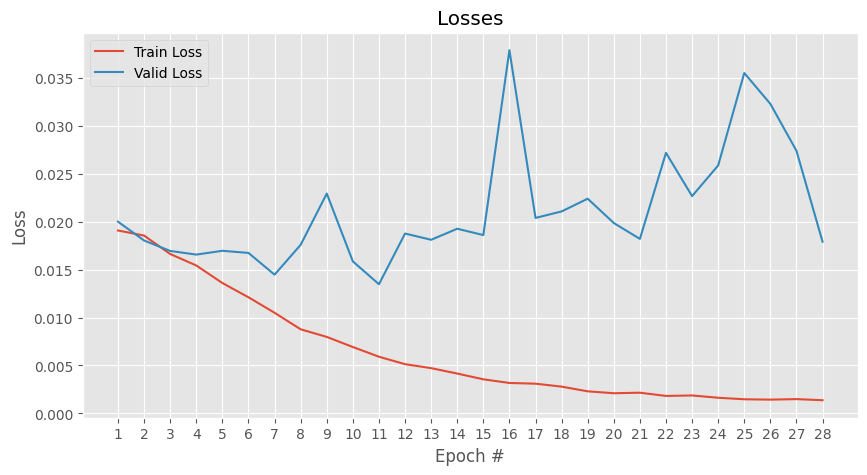

In [13]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
plt.figure(figsize=(10,5))
epoch_ticks = range(1, t + 1)
plt.plot(epoch_ticks, train_loss)
plt.plot(epoch_ticks, valid_loss)
plt.legend(['Train Loss', 'Valid Loss'])
plt.title('Losses') 
plt.xlabel('Epoch #')
plt.ylabel('Loss')
plt.xticks(epoch_ticks)
plt.show()

In [14]:
def predict(dl, ln):
    with torch.no_grad():  # Disable gradient computation for efficiency
        preds, acc, test_acc = [], 0, 0
        for X, y, text_len in dl:
            # Dev data
            pred = model(X, text_len)
            test_acc += torch.sum((pred>=0.5).float() == y)
    return (test_acc/ln).detach().cpu().numpy().item()

In [15]:
predict(x_tr_dl, df_train.shape[0])

0.9865185022354126

In [16]:
predict(x_dev_dl, df_dev.shape[0])

0.8202222585678101

# Predict on sample data

In [117]:
test = pd.read_json('test_data.json', lines=True)['text']
# train = [re.sub(',', '',', '.join([str(x) for x in tok])) for tok in df_train['text']]
test = [[t if t != 0 else 1 for t in ls] for ls in test]

In [120]:
d = [i.split() for i in training_set]
l_ = []
for l in d:
    l_.extend(l)
corpus = Counter(l_)
corpus

Counter({'1': 144584,
         '2': 137047,
         '3': 105939,
         '4': 75809,
         '5': 67093,
         '6': 59951,
         '7': 59067,
         '8': 41587,
         '9': 32837,
         '10': 28527,
         '11': 25750,
         '12': 25347,
         '13': 22099,
         '14': 21463,
         '15': 19923,
         '16': 19563,
         '17': 18848,
         '18': 17835,
         '19': 17604,
         '20': 16386,
         '21': 15762,
         '22': 14398,
         '23': 13709,
         '24': 13030,
         '25': 11790,
         '26': 11121,
         '27': 10929,
         '28': 10651,
         '29': 9002,
         '30': 8607,
         '32': 8493,
         '34': 8363,
         '33': 8181,
         '35': 8118,
         '36': 8020,
         '37': 7904,
         '38': 7740,
         '31': 7287,
         '40': 6844,
         '39': 6760,
         '42': 6132,
         '41': 6053,
         '43': 5862,
         '45': 5815,
         '46': 5784,
         '44': 5777,
         '47

In [121]:
preds = []
for line in test:
    text_tensor = torch.tensor(line).unsqueeze(0).to(device)
    text_length = torch.tensor([len(line)])
    # Pass the sequence and its length to the model
    prediction = model(text_tensor, text_length)
    preds.extend((prediction>=0.5).int().detach().cpu().numpy().reshape(-1))

In [122]:
test_df = pd.DataFrame(columns = ['id', 'value'])
for idx, v in enumerate(preds):
    test_df.loc[idx] = [idx, preds[idx]]
test_df.to_csv('predictions.csv', index=False)

In [123]:
test_df

,id,value
0,0,1
1,1,0
2,2,0
3,3,1
4,4,1
...,...,...
3995,3995,0
3996,3996,0
3997,3997,0
3998,3998,1


In [ ]:
#  Export model
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('model_scripted.pt') # Save

In [ ]:
# Load Model
model = torch.jit.load('model_scripted.pt')
model.eval()